In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score 
import seaborn as sns  #advanced visualization library
import requests, zipfile, io
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('/content/drive/My Drive/DATACEPT COMP5/train.csv')
test = pd.read_csv('/content/drive/My Drive/DATACEPT COMP5/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/DATACEPT COMP5/sample_submission.csv')

In [ ]:
train.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Uganda,2018,uniqueid_807,Rural,No,9,40,Female,Spouse,Married/Living together,No formal education,Self employed,0
1,Rwanda,2016,uniqueid_7215,Rural,Yes,3,55,Male,Head of Household,Married/Living together,No formal education,Informally employed,0
2,Kenya,2018,uniqueid_5248,Rural,Yes,4,32,Female,Spouse,Married/Living together,Primary education,Farming and Fishing,1
3,Uganda,2018,uniqueid_2020,Urban,Yes,3,23,Female,Spouse,Married/Living together,Secondary education,Other Income,0
4,Uganda,2018,uniqueid_1324,Rural,No,3,60,Female,Head of Household,Widowed,Secondary education,Self employed,0


In [ ]:
train.dtypes

country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
bank_account               int64
dtype: object

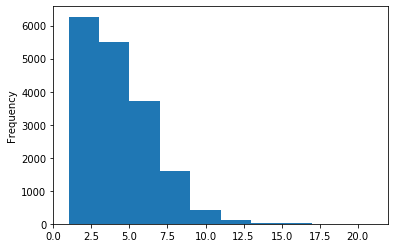

In [ ]:
train.household_size.plot(kind="hist")

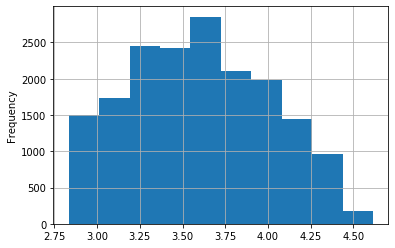

In [ ]:
x=np.log1p(train.age_of_respondent)
x.plot(kind='hist',bins=10,grid=True)

In [ ]:
Y=train.bank_account

In [ ]:
missing_percentage=(train.isna().sum()/len(train)).sort_values(ascending=False)
missing_percentage

bank_account              0.0
job_type                  0.0
education_level           0.0
marital_status            0.0
relationship_with_head    0.0
gender_of_respondent      0.0
age_of_respondent         0.0
household_size            0.0
cellphone_access          0.0
location_type             0.0
uniqueid                  0.0
year                      0.0
country                   0.0
dtype: float64

In [ ]:
all_data = pd.concat((train, test)).reset_index(drop = True)


In [ ]:

new=train.groupby('job_type')['bank_account'].agg({'bank_account_per_job_type':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='job_type',right_on='job_type')

new=train.groupby('education_level')['bank_account'].agg({'bank_account_per_education_level':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='education_level',right_on='education_level')

new=train.groupby('relationship_with_head')['bank_account'].agg({'bank_account_per_relationship_with_head':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='relationship_with_head',right_on='relationship_with_head')

new=train.groupby('marital_status')['bank_account'].agg({'bank_account_per_marital_status':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='marital_status',right_on='marital_status')

new=train.groupby('country')['bank_account'].agg({'bank_account_per_country':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='country',right_on='country')

new=train.groupby('year')['bank_account'].agg({'bank_account_per_year':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='year',right_on='year')

new=train.groupby('cellphone_access')['bank_account'].agg({'bank_account_per_cellphone_access':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='cellphone_access',right_on='cellphone_access')

new=train.groupby('location_type')['bank_account'].agg({'bank_account_per_location_type':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='location_type',right_on='location_type')

new=train.groupby('gender_of_respondent')['bank_account'].agg({'bank_account_per_gender_of_respondent':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='gender_of_respondent',right_on='gender_of_respondent')

In [ ]:
train= all_data[:len(Y)]
test= all_data[len(Y):]


In [ ]:
test=test.drop("bank_account",axis=1)

In [ ]:
to_drop=["uniqueid","bank_account"]

In [ ]:
train=train.drop(to_drop,axis=1)

In [ ]:
train=pd.get_dummies(train)

In [ ]:
train.shape

(17643, 49)

# Modelling

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train,Y , test_size=0.20, random_state=4)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_X, train_y)
val_pred_clf=clf.predict(val_X)
val_mae_clf = roc_auc_score(val_pred_clf, val_y)
print(val_mae_clf)

0.7947339804602546


In [ ]:
import xgboost as xgb
xgb_model =xgb.XGBClassifier(gamma=0, 
                             learning_rate=0.1, max_depth=8, 
                             n_estimators=500,
                             tree_method='gpu_hist' )
xgb_model=xgb_model.fit(train_X, train_y)
val_pred_xgb = xgb_model.predict_proba(val_X)
#val_mae_xgb = roc_auc_score(val_pred_xgb, val_y)
#print(val_mae_xgb)


In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(colsample_bytree=0.4,
                 learning_rate=0.1,
                 max_depth=12,
                 min_child_weight=1.5,
                 n_estimators=500,                                                                   
                 subsample=0.6,
                 seed=42)
lgb_model.fit(train_X,train_y)
val_pred_lgb = lgb_model.predict_proba(val_X)
val_mae_lgb = roc_auc_score(val_pred_lgb, val_y)
print(val_mae_lgb)

In [ ]:
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy


In [ ]:
svc_model = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)
svc_model.fit(train_X,train_y)
val_pred_svc = svc_model.predict(val_X)
val_mae_svc = roc_auc_score(val_pred_svc, val_y)
print(val_mae_svc)

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 8,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)
rf.fit(train_X,train_y)
val_pred_rf = rf.predict(val_X)
val_mae_rf = roc_auc_score(val_pred_rf, val_y)
print(val_mae_rf)

0.8700526547830183


In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(20,50,4), max_iter=300,activation = 'relu',solver='adam',random_state=1)
nn.fit(train_X,train_y)
val_pred = nn.predict(val_X)
val_mae_nn = roc_auc_score(val_pred, val_y)
print(val_mae_nn)

0.8384169795864053


In [ ]:
#Execute only once
#pip install catboost

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=500,
                          learning_rate=0.1,
                          depth=8)
model.fit(train_X,train_y)
val_pred = model.predict(val_X)
val_mae = roc_auc_score(val_pred, val_y)
print(val_mae)

0:	learn: 0.5920096	total: 13.5ms	remaining: 6.75s
1:	learn: 0.5209810	total: 21.2ms	remaining: 5.28s
2:	learn: 0.4629227	total: 32.9ms	remaining: 5.46s
3:	learn: 0.4286115	total: 40.6ms	remaining: 5.04s
4:	learn: 0.3950922	total: 52ms	remaining: 5.14s
5:	learn: 0.3704267	total: 62.9ms	remaining: 5.18s
6:	learn: 0.3504482	total: 74ms	remaining: 5.21s
7:	learn: 0.3359942	total: 84.9ms	remaining: 5.22s
8:	learn: 0.3230020	total: 96.4ms	remaining: 5.26s
9:	learn: 0.3139327	total: 107ms	remaining: 5.25s
10:	learn: 0.3075615	total: 118ms	remaining: 5.24s
11:	learn: 0.3017979	total: 129ms	remaining: 5.24s
12:	learn: 0.2971599	total: 140ms	remaining: 5.25s
13:	learn: 0.2935051	total: 151ms	remaining: 5.23s
14:	learn: 0.2885058	total: 162ms	remaining: 5.25s
15:	learn: 0.2857324	total: 173ms	remaining: 5.24s
16:	learn: 0.2828397	total: 185ms	remaining: 5.26s
17:	learn: 0.2802023	total: 196ms	remaining: 5.25s
18:	learn: 0.2785987	total: 204ms	remaining: 5.16s
19:	learn: 0.2764349	total: 219ms	re

In [ ]:
sclf = StackingCVClassifier(classifiers = [nn, model, xgb_model,lgb_model,clf],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = SVC(probability = True))

In [ ]:
sclf.fit(train_X.values,train_y.values)

0:	learn: 0.5947753	total: 10.1ms	remaining: 5.04s
1:	learn: 0.5246625	total: 16.8ms	remaining: 4.19s
2:	learn: 0.4659514	total: 26.3ms	remaining: 4.36s
3:	learn: 0.4282578	total: 33ms	remaining: 4.09s
4:	learn: 0.3972822	total: 40ms	remaining: 3.96s
5:	learn: 0.3740386	total: 49.5ms	remaining: 4.08s
6:	learn: 0.3563491	total: 59ms	remaining: 4.16s
7:	learn: 0.3390487	total: 69.7ms	remaining: 4.29s
8:	learn: 0.3261871	total: 79.9ms	remaining: 4.36s
9:	learn: 0.3170873	total: 89.9ms	remaining: 4.4s
10:	learn: 0.3077195	total: 100ms	remaining: 4.46s
11:	learn: 0.3014629	total: 110ms	remaining: 4.48s
12:	learn: 0.2969424	total: 120ms	remaining: 4.5s
13:	learn: 0.2924381	total: 133ms	remaining: 4.63s
14:	learn: 0.2888356	total: 146ms	remaining: 4.71s
15:	learn: 0.2848979	total: 157ms	remaining: 4.76s
16:	learn: 0.2807798	total: 169ms	remaining: 4.79s
17:	learn: 0.2785587	total: 179ms	remaining: 4.79s
18:	learn: 0.2759788	total: 189ms	remaining: 4.79s
19:	learn: 0.2740562	total: 200ms	remai

StackingCVClassifier(classifiers=[MLPClassifier(activation='relu', alpha=0.0001,
                                                batch_size='auto', beta_1=0.9,
                                                beta_2=0.999,
                                                early_stopping=False,
                                                epsilon=1e-08,
                                                hidden_layer_sizes=(20, 50, 4),
                                                learning_rate='constant',
                                                learning_rate_init=0.001,
                                                max_fun=15000, max_iter=300,
                                                momentum=0.9,
                                                n_iter_no_change=10,
                                                nesterovs_momentum=True,
                                                power_t=0.5, random_state=1,
                                                shuf...
   

In [ ]:
val_pred_sclf=sclf.predict_proba(val_X.values)
val_pred_sclf = sclf.predict(val_X.values)
val_mae_sclf = roc_auc_score(val_pred_sclf, val_y)
print(val_mae_sclf)

0.8263944686429568


In [ ]:
val_pred = sclf.predict(val_X)
val_mae_nn = roc_auc_score(val_pred, val_y)
print(val_mae_nn)

# Testing

In [ ]:
to_drop2=["uniqueid"]

In [ ]:
test=test.drop(to_drop2,axis=1)

In [ ]:
test=pd.get_dummies(test)

In [ ]:
test.shape

(5881, 49)

In [ ]:
test.head()

,age_of_respondent,household_size,year,bank_account_per_job_type,bank_account_per_education_level,bank_account_per_relationship_with_head,bank_account_per_marital_status,bank_account_per_country,bank_account_per_year,bank_account_per_cellphone_access,bank_account_per_location_type,bank_account_per_gender_of_respondent,cellphone_access_No,cellphone_access_Yes,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,gender_of_respondent_Female,gender_of_respondent_Male,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,location_type_Rural,location_type_Urban,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse
17643,22,7,2018,0.079187,0.082898,0.086258,0.122398,0.251274,0.208128,0.018934,0.176991,0.188609,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
17644,46,3,2018,0.079187,0.082898,0.086258,0.114765,0.251274,0.208128,0.182963,0.117488,0.107605,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
17645,52,6,2018,0.115016,0.082898,0.176349,0.172538,0.251274,0.208128,0.182963,0.117488,0.188609,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
17646,68,2,2017,0.195000,0.082898,0.176349,0.122398,0.093800,0.093800,0.182963,0.176991,0.188609,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
17647,38,7,2018,0.097433,0.236867,0.107775,0.172538,0.251274,0.208128,0.182963,0.176991,0.107605,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
ids=sample_submission.ID

In [ ]:
test_preds_xgb = xgb_model.predict_proba(test)

l=[]
for i in range(len(test_preds_xgb)):
  l.append(test_preds_xgb[i][0])
test_preds_xgb=l

In [ ]:
# make predictions which we will submit. 

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_xgb)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_xgb.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_lgb = lgb_model.predict(test)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_lgb)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_lgb.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_clf = clf.predict(test)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_clf)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_clf.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_nn = nn.predict(test)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_nn)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_nn.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_cat = model.predict(test)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_cat)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_cat.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_rf = rf.predict(test)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_rf)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_rf.csv', index=False)

In [ ]:
# make predictions which we will submit. 
test_preds_sclf = sclf.predict(test.values)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.
output = pd.DataFrame({'ID': ids, 'bank_account': (test_preds_sclf)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP5/sub_sclf.csv', index=False)